In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.plotting import *
from aeons.endpoint import *
from aeons.regress import analytic_lm_params

In [128]:
def get_logXfs(model, method, iterations, Nset=25, epsilon=1e-3, **kwargs):
    """Method takes in arguments (ndead, logL, nk, logZdead, Nset, **kwargs) and returns logXfs_set"""
    N = len(iterations)
    logXfs = np.zeros(N)
    logXfs_std = np.zeros(N)
    for i, ndead in enumerate(iterations):
        logL, X_mean, nk, logZdead = model.data(ndead)
        try:
            logXfs_set, message = method(ndead, logL, nk, logZdead, Nset, **kwargs)
            logXfs[i] = np.mean(logXfs_set)
            logXfs_std[i] = np.std(logXfs_set)
            print('\r', f"Iteration {ndead} of {iterations[-1]}, {len(logXfs_set)} samples", end='')
        except:
            logXfs[i] = np.nan
            logXfs_std[i] = np.nan
            print('\r', f"Iteration {ndead} of {iterations[-1]}, model bad", end='')
    return logXfs, logXfs_std

In [79]:
def get_best_window(ndead, logL, X_mean, logZdead):
    nlive = len(logL) - ndead
    N_range = 8
    min_range = nlive//N_range
    max_range = nlive * N_range
    windows = np.logspace(np.log10(min_range), np.log10(max_range), 2*N_range + 1, dtype=int)
    logZs = np.zeros(len(windows))
    for i, window in enumerate(windows):
        logLd = logL[-window:]
        Xd = X_mean[-window:]
        reg = GaussianRegress(logLd, Xd)
        logZ = reg.logZ() - (len(logL) - window) * np.log(logLd.max() - logLd.min())
        logXf = logXf_formula(reg.theta, logZdead, X_mean[ndead])
        if np.isnan(logXf):
            logZ = -np.inf
        logZs[i] = logZ
    return windows[np.argmax(logZs)]

def window_fitter(ndead, logL, nk, logZdead, Nset):
    X_mean = X_mu(nk)
    window = get_best_window(ndead, logL, X_mean, logZdead)
    logXf_set = np.zeros(Nset)
    logLd = logL[-window:]
    for i in range(Nset):
        X = generate_Xs(nk)
        Xd = X[-window:]
        reg = GaussianRegress(logLd, Xd)
        logXf_set[i] = logXf_formula(reg.theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set, 3)
    return logXf_set

In [121]:
def get_start(ndead, logL, X_mean):
    nlive = len(logL) - ndead
    start = ndead
    min_start = ndead - 5*nlive
    while start > min_start:
        logLd = logL[start:]
        Xd = X_mean[start:]
        reg = GaussianRegress(logLd, Xd)
        if reg.theta[1]/2 > 180:
            start -= 2 * nlive
        else:
            return start
    raise ValueError("Could not find a good start point")

def extender(ndead, logL, nk, logZdead, Nset, message=False):
    X_mean = X_mu(nk)
    start = get_start(ndead, logL, X_mean)
    logLd = logL[start:]
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        Xd = X[start:]
        theta = analytic_lm_params(logLd, Xd, d0=1)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set, 3)
    message = f"{len(logXf_set)}"
    if message:
        return logXf_set, message
    return logXf_set

In [147]:
name, samples = get_samples('toy', 'planck_gaussian')
# name, samples = get_samples('lcdm', 'BAO')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]
true_endpoint

27474

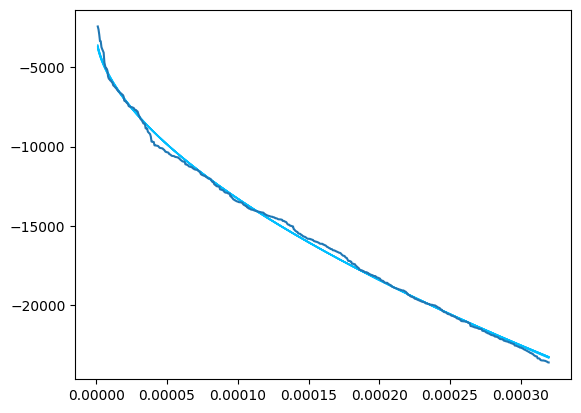

In [156]:
ndead = 5000
logL, X_mean, nk, logZdead = model.data(ndead)
reg = GaussianRegress(logL[ndead:], X_mean[ndead:])
theta, cov = reg.theta, reg.covtheta()
for i in range(10):
    t = np.random.multivariate_normal(theta, cov)
    plt.plot(X_mean[ndead:], full.func(X_mean[ndead:], t), lw=1, color='deepskyblue')
plt.plot(X_mean[ndead:], logL[ndead:])
# plt.ylim(logL[ndead:].min(), logL[ndead:].max())

In [137]:
np.sqrt(cov)

/tmp/ipykernel_41261/2717691675.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(cov)


array([[3.20957494e+04, 1.78193384e+04,            nan],
       [1.78193384e+04, 9.89326980e+03,            nan],
       [           nan,            nan, 1.79585780e-03]])

In [125]:
ndead = 30000
logL, X_mean, nk, logZdead = model.data(ndead)
extender(ndead, logL, nk, logZdead, Nset=25)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


array([-118.67484747,  -87.03633826, -129.34573377, -114.57010751,
        -98.35572553, -104.89109357,  -94.33868563,  -86.89482834,
        -87.41501839, -113.48250235,  -98.10834846,  -97.72172387,
       -102.20909276,  -79.44846337, -110.76697512, -123.49223296,
       -102.63755302, -125.75735995, -115.45581348,  -90.44145601,
       -113.59671594,  -91.07390399])

In [129]:
iterations = make_iterations(true_endpoint, 25)
logXfs, logXfs_std = get_logXfs(model, extender, iterations, Nset=25)

 Iteration 8071 of 88235, 22 samples

/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 15042 of 88235, 19 samples

/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 22013 of 88235, 24 samples

/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 25498 of 88235, 21 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 32469 of 88235, model bads

/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)


 Iteration 39440 of 88235, model bad

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 42925 of 88235, 22 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 46410 of 88235, 15 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 53381 of 88235, 23 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 56867 of 88235, 18 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 63837 of 88235, model bads

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 70808 of 88235, model bads

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 74294 of 88235, 17 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 77779 of 88235, 20 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 81264 of 88235, 22 samples

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:113: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 88235 of 88235, 24 samples

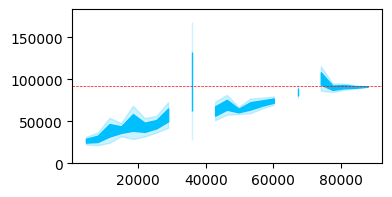

In [130]:
logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = calc_endpoints(iterations, logXs, logXfs, logXfs_std, nlive=500)
plot_std(iterations, endpoints, endpoints_std, true_endpoint, ylim=(0, 2))

In [23]:
x = window_fitter(ndead, logL, nk, logZdead, Nset=50)
x, len(x)

(array([-164.26128395, -144.80609513, -106.6935678 , -113.19701862,
        -141.70358521, -125.49048841, -152.79795889, -118.79497041,
        -109.09422084, -127.97023581, -121.90109039, -213.16270435,
        -149.94313987, -130.98886607, -177.29662883, -113.28803484,
        -201.6088542 , -206.12069617, -118.97575971, -141.50472214,
        -133.68612121, -181.71715738, -192.38287705, -149.00250957,
        -131.21667182]),
 25)

array([6.52039376, 5.7900605 , 5.56952513, 5.14853143, 5.2385781 ,
       5.42278988, 5.64507816, 5.75399995, 5.69874224, 5.63750138,
       5.57909592, 5.60922627, 5.72720885, 5.78987403, 5.84453563,
       5.89954786, 5.94323598, 5.91974932, 5.85253484, 5.80335735,
       5.76637362, 5.6941195 , 5.66348635, 5.63348696, 5.60481695])

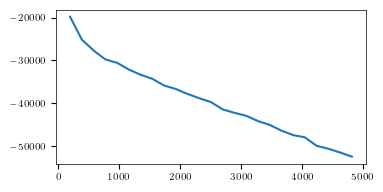

In [123]:
nlive = len(logL) - ndead
min_range = nlive//5
max_range = nlive * 5
windows = np.arange(min_range, max_range, min_range)
logZs = np.zeros(len(windows))
ds = np.zeros(len(windows))
for i, window in enumerate(windows):
    logLd = logL[-window:]
    Xd = X_mean[-window:]
    reg = GaussianRegress(logLd, Xd)
    logZ = reg.logZ() - (len(logL) - window) * np.log(logLd.max() - logLd.min())
    logXf = logXf_formula(reg.theta, logZdead, X_mean[ndead])
    if np.isnan(logXf):
        logZ = -np.inf
    logZs[i] = logZ
    ds[i] = reg.theta[1]
plt.plot(windows, logZs)
ds

 Iteration 930 of 17904, 21 samples2 attempts
2 attempts
2 attempts
 Iteration 1637 of 17904, 21 samples2 attempts
2 attempts
2 attempts
2 attempts
2 attempts
 Iteration 3759 of 17904, 22 samples2 attempts
 Iteration 5174 of 17904, 20 samples2 attempts
2 attempts
2 attempts
2 attempts
 Iteration 5881 of 17904, 18 samples2 attempts
 Iteration 6588 of 17904, 19 samples2 attempts
2 attempts
 Iteration 7295 of 17904, 19 samples2 attempts
 Iteration 8003 of 17904, 19 samples2 attempts
2 attempts
2 attempts
2 attempts
 Iteration 17904 of 17904, 19 samples

Text(0.5, 1.0, 'DKL = 26.66')

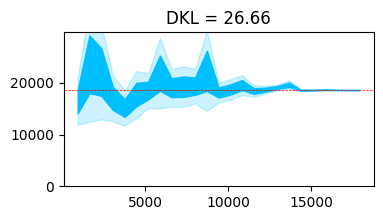

In [9]:
from aeons.toy_samples import gaussian_samples
samples = gaussian_samples(500, 8, 0.01, seed=1)

model = EndModel(samples)
true_endpoint = model.true_endpoint()
iterations = make_iterations(true_endpoint, 25)
logXfs, logXfs_std = model.logXfs(theta_bandwidth_trunc, iterations, Nset=25, splits=1)

logXs = samples.logX().iloc[iterations]
endpoints, endpoints_std = calc_endpoints(iterations, logXs, logXfs, logXfs_std, nlive=500)
plot_std(iterations, endpoints, endpoints_std, true_endpoint, ylim=(0, 1.6))
plt.title(f"DKL = {samples.D_KL():.2f}")